In [1]:
path = '/home/flomik/Desktop/Code-PHD/COCOMO_txn/results/networks/'
name = 'Co_expression_3_layers'

In [2]:
import sklearn, leidenalg, itertools, random
import pandas as pd
import numpy as np
import igraph as ig
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests
import gseapy as gp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def my_correlation(file):
    """
        perform spearman correlation from file of values
        Args:
            file (str): pandas.core.frame.DataFrame with samples as column and features as rows
        Returns:
            PRmatrix(str): Correlation table
    """
    Rmatrix, Pmatrix= sp.stats.spearmanr(file.T)
    Rmatrix=pd.DataFrame(Rmatrix, index=data.index.copy(), columns=data.index.copy())
    Pmatrix=pd.DataFrame(Pmatrix, index=data.index.copy(), columns=data.index.copy())

    ###Prepares R and P matrices
    Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(np.bool))
    Psquared.columns.name='Feat2'
    Pmatrix=Pmatrix.stack()
    Pmatrix.index.names=['v1','v2']
    Pmatrix=Pmatrix.reset_index()
    Pmatrix.columns=['feat1','feat2','P']

    Rmatrix=Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(np.bool))
    Rmatrix.columns.name='Feat2'
    Rmatrix=Rmatrix.stack()
    Rmatrix.index.names=['v1','v2'] #Avoid stacked names colliding
    Rmatrix=Rmatrix.reset_index()
    Rmatrix.columns=['feat1','feat2','R']

    PRmatrix=pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['feat1','feat2']) #Correlation matrix with both R and P
    PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2].dropna()
    
    ### Calculate FDR 
    FDR=pd.DataFrame(multipletests(PRmatrix['P'], method='fdr_bh', alpha=0.01)[1], columns=['FDR'])
    PRmatrix=pd.concat([ PRmatrix, FDR], axis=1)
    
    return(PRmatrix)

In [4]:
## load data
txn=pd.read_csv('/home/flomik/Desktop/Code-PHD/COCOMO_txn/processing/COCOMO_transcriptomics_vsd_data_deseq2_filt.csv', index_col=0)
prot=pd.read_csv('/home/flomik/Desktop/Code-PHD/COCOMO_txn/processing/COCOMO_proteomics_olink_filt.csv', index_col=0)
met=pd.read_csv('/home/flomik/Desktop/Code-PHD/COCOMO_txn/processing/COCOMO_metabolomics_metabolon_filt.csv', index_col=0)

In [5]:
a = len(txn.columns)
b = len(met.columns)
c = len(prot.columns)
a + b + c

7172

In [6]:
## make table conversion
conv_1 = pd.DataFrame({'feat1':txn.columns,
                   'type_1': ["txn"]*len(txn.columns),
                  }, columns = ['feat1', 'type_1'])
conv_2 = pd.DataFrame({'feat1':met.columns,
                   'type_1': ["met"]*len(met.columns),
                  }, columns = ['feat1', 'type_1'])
conv_3 = pd.DataFrame({'feat1':prot.columns,
                   'type_1': ["prot"]*len(prot.columns),
                  }, columns = ['feat1', 'type_1'])
conv = pd.concat([conv_1, conv_2, conv_3])

In [7]:
metabolites = ['caprate (10:0)', '1-linoleoyl-GPG (18:2)*', '1-oleoyl-GPG (18:1)*']

conv_2

len(conv_2[conv_2['feat1'].isin(metabolites)])

enr = gp.enrichr(gene_list= metabolites,description= "Lipids" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_met.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/3_layers_integration/results/MSEA_Metabolites',cutoff=0.5,verbose=True, background  = 1143)


if enr.results.empty:
    print('DataFrame is empty!')

2022-11-30 14:29:26,511 User Defined gene sets is given: /home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_met.gmt
2022-11-30 14:29:26,575 Connecting to Enrichr Server to get latest library names
2022-11-30 14:29:26,577 No hits return, for gene set: Custom139987166205256


DataFrame is empty!


In [8]:
input = path + 'type_features' + name + '.csv'
conv.to_csv(input, index=False)

In [9]:
## Set empty dataframe
df= pd.DataFrame(columns = ['Comp', 'Comp_type', 'R', 'I'])
df

,Comp,Comp_type,R,I


In [11]:
data = pd.read_csv("/home/flomik/Desktop/Code-PHD/COCOMO_txn/processing/data_merged_co_expression_network_features_consensus.csv", index_col=0)

In [12]:
data = np.transpose(data)

In [13]:
data.head()

,1903,1267,1756,1608,1368,1155,1114,1284,1370,1576,...,1888,1149,1914,1198,1475,1920,1996,1108,1271,1397
(12 or 13)-methylmyristate (a15:0 or i15:0),0.616169,1.058732,-0.662689,2.434401,-0.244856,-1.397448,-0.665889,-1.100360,-0.121235,-0.582728,...,-0.923031,-1.203901,0.835762,-0.674614,1.220701,-0.522012,0.023042,-0.852303,-1.091725,0.429643
(14 or 15)-methylpalmitate (a17:0 or i17:0),0.314871,1.442970,-0.742507,1.970375,0.081203,-1.831358,0.420509,-0.934566,0.112633,-0.488836,...,-1.118727,-1.465938,0.323082,-0.594008,0.833335,-0.395549,-0.185901,-1.241612,-0.872499,-0.363085
(16 or 17)-methylstearate (a19:0 or i19:0),0.266517,1.364068,-0.441634,1.384768,-0.273866,-1.341537,0.804054,-0.360860,-0.167312,-0.544982,...,-0.781405,-0.922210,0.159500,-0.339163,0.802483,-0.494922,0.425352,-0.762681,-0.794357,-0.767585
(2 or 3)-decenoate (10:1n7 or n8),-0.096036,0.273098,0.113967,0.716245,1.180975,-2.716908,-2.716908,-1.373327,0.545870,-0.990223,...,-2.716908,-1.330973,0.780730,-2.716908,-0.180005,-0.367360,-0.517875,-0.449493,-2.716908,-2.716908
"(2,4 or 2,5)-dimethylphenol sulfate",3.250583,-3.373327,-1.578629,1.295194,-1.014500,1.140190,-3.029146,0.836490,-1.667034,2.074026,...,1.650305,-3.373327,-0.658356,-1.746616,3.393059,1.485684,2.923796,4.237220,-3.373327,-1.423139


In [14]:
PRmatrix= my_correlation(data)

In [15]:
PRmatrix.head()

,feat1,feat2,R,P,FDR
0,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),0.837174,9.972629e-43,1.182525e-39
1,(12 or 13)-methylmyristate (a15:0 or i15:0),(16 or 17)-methylstearate (a19:0 or i19:0),0.731516,9.794271e-28,2.917238e-25
2,(12 or 13)-methylmyristate (a15:0 or i15:0),(2 or 3)-decenoate (10:1n7 or n8),0.518795,2.892088e-12,1.706761e-10
3,(12 or 13)-methylmyristate (a15:0 or i15:0),"(2,4 or 2,5)-dimethylphenol sulfate",-0.038495,6.310815e-01,8.553275e-01
4,(12 or 13)-methylmyristate (a15:0 or i15:0),(N(1) + N(8))-acetylspermidine,0.055474,4.887538e-01,7.738940e-01


In [16]:
PRmatrix.loc[PRmatrix['FDR']<0.00005,'R'].shape

(463646,)

In [17]:
PRmatrix = PRmatrix.loc[PRmatrix['FDR']<0.00005,]

In [18]:
fdr_pos_mat=PRmatrix.loc[PRmatrix['R']>0]
fdr_neg_mat=PRmatrix.loc[PRmatrix['R']<0]
PRmatrix=PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,]

In [19]:
fdr_pos_mat.shape

(381520, 5)

In [20]:
fdr_neg_mat.shape

(82126, 5)

In [21]:
input = path + 'network_correlation_positive_' + name +'.csv'
fdr_pos_mat.to_csv(input, index=False)
input = path + 'network_correlation_positive_' + name +'.txt'
fdr_pos_mat.to_csv(input, sep='\t', mode='a')
input = path + 'network_correlation_positive_' + name +'.xlsx'
fdr_pos_mat.to_excel(input, index = False)

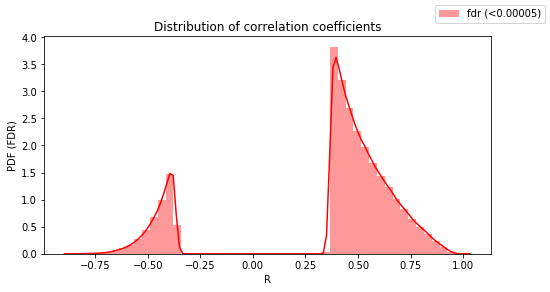

In [22]:
shortPR=PRmatrix.copy().loc[:,['feat1','feat2','R']]
shortPR=shortPR.loc[shortPR.feat1!=shortPR.feat2]

fig=plt.figure(figsize=(8,4))
g=sns.distplot(shortPR['R'][shortPR['R']!=0], color='r');
g.set(ylabel='PDF (FDR)')

fig.legend(labels=['fdr (<0.00005)']);
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
input = path + 'distribution_corr_coeff_'+ name + 'svg'
plt.savefig(input, format='svg', dpi=1200)

plt.show()

In [23]:
pos_w=ig.Graph.TupleList([tuple(x) for x in fdr_pos_mat.values], directed=False, edge_attrs=['w'])

#negative association, weighted
neg_w=ig.Graph.TupleList([tuple(x) for x in fdr_neg_mat.values], directed=False, edge_attrs=['w'])

#random network, unweighted, node and edge number based on a network of the same size
randomG=ig.Graph.Erdos_Renyi(
    n=pos_w.vcount(), 
    m=pos_w.ecount(), directed=False, loops=False)

randomG_2=ig.Graph.Erdos_Renyi(
    n=neg_w.vcount(), 
    m=neg_w.ecount(), directed=False, loops=False)

In [24]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pos_w, neg_w, randomG, randomG_2]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['pos_w','neg_w', 'random', 'random_2']
network_stats

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale='log', xscale='log')
p=sp.stats.probplot(pos_w.degree(), plot=ax)
k=sp.stats.probplot(neg_w.degree(), plot=ax)
r=sp.stats.probplot(randomG.degree(), plot=ax)
s=sp.stats.probplot(randomG_2.degree(), plot=ax)

col=['blue','','lightsalmon','','green', '','red']
for x in np.arange(0,7,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['pos_w','pos_w','neg_w','neg_w','random','random', 'random_2','random_2']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
input = path + 'Networks_degree_' + name + '.svg'
plt.savefig(input, format='svg', dpi=1200)
plt.show()

In [ ]:
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition, weights='w')

In [ ]:
leidenalg.ModularityVertexPartition
leidenalg.CPMVertexPartition

In [ ]:
def Average(lst): 
    return sum(lst) / len(lst)

In [ ]:
metabolites = pd.Series(pos_w.vs['name'])
len(metabolites)
for i in range(19):
    print(len(metabolites[pos_w_comm[i]]))

In [ ]:
## MSEA + centrality
cutoff = 0.1

network =[]
community = []
connectivity = []
communities_stats = []
n_metabolites = []
transitivity = []
proportion_met = []
proportion_lip = []
proportion_mic = []
tot_terms_met = []
tot_terms_lip = []
tot_terms_mic = []


tot_nb =[]

c = 0

d = pd.DataFrame()

net = [pos_w]
com_net = [pos_w_comm]
names = ['pos_w']

for j in [0]:
    average = []
    a = 1
    terms_enriched = []
    for i in com_net[j]:
        if(len(i)<31):
            continue
        c = i
        degree = pd.Series(net[j].degree())
        metabolites = pd.Series(net[j].vs['name'])
        degree = degree[c]
        metabolites = metabolites[c]
        metabolites = metabolites.tolist()
        
        if (len(conv_2[conv_2['feat1'].isin(metabolites)]) > 10):
            metabolites_2 = pd.Series(conv_2['feat1'][conv_2['feat1'].isin(metabolites)]).tolist()
            prop = len(metabolites_2)
            proportion_met.append(prop)
            
            enr = gp.enrichr(gene_list= metabolites, description= "Metabolites" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/COCOMO_txn/processing/Metabolon_met.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/COCOMO_txn/results/co_expression',cutoff=0.5,verbose=True, background  = 841)

            if enr.results.empty:
                print('DataFrame is empty!')
                tot_terms_met.append('Not')
            else :
                results=enr.results.sort_values('Adjusted P-value', ascending=True)
                print(results)
                results=results.loc[results['Adjusted P-value']<cutoff,]
                terms_enriched = results['Term'].tolist()
                terms_enriched = terms_enriched
                terms_enriched = ','.join(terms_enriched)
                tot_terms_met.append(terms_enriched)
        else :
            tot_terms_met.append('Not')
            proportion_met.append('Not')
        
        if (len(conv_1[conv_1['feat1'].isin(metabolites)]) > 10):
            metabolites_2 = pd.Series(conv_1['feat1'][conv_1['feat1'].isin(metabolites)]).tolist()
            prop = len(metabolites_2)
            proportion_lip.append(prop)
            
            enr = gp.enrichr(gene_list= metabolites,description= "Transcripts" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/COCOMO_txn/data/MSEA/KEGG_1_3_5.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/COCOMO_txn/results/co_expression',cutoff=0.5,verbose=True, background  = 1143)
            
            
            if enr.results.empty:
                print('DataFrame is empty!')
                tot_terms_lip.append('Not')
                
            else :
                results=enr.results.sort_values('Adjusted P-value', ascending=True)
                print(results)
                results=results.loc[results['Adjusted P-value']<cutoff,]
                terms_enriched = results['Term'].tolist()
                terms_enriched = terms_enriched
                terms_enriched = ','.join(terms_enriched)
                tot_terms_lip.append(terms_enriched)
            
        else :
            tot_terms_lip.append('Not')
            proportion_lip.append('Not')
        
        if (len(conv_3[conv_3['feat1'].isin(metabolites)]) > 10):
            
            metabolites_2 = pd.Series(conv_3['feat1'][conv_3['feat1'].isin(metabolites)]).tolist()
            prop = len(metabolites_2)
            proportion_mic.append(prop)
            
            enr = gp.enrichr(gene_list= metabolites,description= "Proteins" + str(a),
                       gene_sets="/home/flomik/Desktop/Code-PHD/COCOMO_txn/data/MSEA/KEGG_1_3_5.gmt",
                       outdir='/home/flomik/Desktop/Code-PHD/COCOMO_txn/results/co_expression',cutoff=0.5,verbose=True, background  = 241)
            
            if enr.results.empty:
                print('DataFrame is empty!')
                tot_terms_mic.append('Not')
            else :
                results=enr.results.sort_values('Adjusted P-value', ascending=True)
                print(results)
                results=results.loc[results['Adjusted P-value']<cutoff,]
                terms_enriched = results['Term'].tolist()
                terms_enriched = terms_enriched
                terms_enriched = ','.join(terms_enriched)
                tot_terms_mic.append(terms_enriched)
                
        else :
            tot_terms_mic.append('Not')
            proportion_mic.append('Not')
        
        print("average connectivity of the community number ", a, "which contains", len(c), " metabolites is", round(Average(degree), 2), "for network", names[j])
        
        average.append(Average(degree))
        communities_stats.append((a,len(c),round(Average(degree), 2)))
        network.append(names[j])
        connectivity.append(round(Average(degree), 2))
        community.append(a)
        n_metabolites.append(len(c))
        v = net[j].transitivity_local_undirected(vertices = metabolites)
        transitivity.append(round(Average(v), 2))
        a = a +1
        
        
print(len(network))
print(len(connectivity))
print(len(n_metabolites))
print(len(transitivity))
print(len(tot_terms_met))
print(len(tot_terms_lip))
print(len(tot_terms_mic))
print(len(proportion_met))
print(len(proportion_lip))
print(len(proportion_mic))

df = pd.DataFrame({'Network_name':network,
                   'Connectivity':connectivity,
                   'Number_community':community,
                   'N_metabolites':n_metabolites,
                   'Clustering_coeff':transitivity,
                   'Terms_Metabolites':tot_terms_met,
                   'Terms_Lipids':tot_terms_lip,
                   'Terms_Microbiome':tot_terms_mic,
                   'Prop_met' : proportion_met,
                   'Prop_lip' : proportion_lip,
                   'Prop_mic' : proportion_mic,
                  })



input = path + 'Results_centrality_networks_CPM' + name + '.csv'
df.to_csv(input, index=False)


In [ ]:
df_1 = pd.DataFrame({'feat1':['1'],
                   'Degree': ['1'],
                   'Network':['1'],
                   'Community':['1']
                  })

df_1

In [ ]:
net = [pos_w]
com_net = [pos_w_comm]
names = ['pos_w']

for j in [0]:
    average = []
    a = 1
    for i in com_net[j]:
        tot_metabolites =[]
        tot_degree = []
        tot_network = []
        community = []
        if(len(i)<30):
            continue
        c = i
        degree = pd.Series(net[j].degree())
        metabolites = pd.Series(net[j].vs['name'])
        degree = degree[c]
        degree = degree.tolist()
        metabolites = metabolites[c]
        metabolites = metabolites.tolist()
        tot_network = [names[j]]*len(c)
        community = [a]*len(c)
        tot_degree = degree
        tot_metabolites = metabolites
        df_2 = pd.DataFrame({'feat1':tot_metabolites,
                   'Degree': tot_degree,
                   'Network': tot_network,
                   'Community':community,
                  }, columns = ['feat1', 'Degree', 'Network', 'Community'])
        df_1 = pd.concat([df_1, df_2], sort=False)
        a = a +1

#        

In [ ]:
df_1 = df_1.merge(conv, on='feat1')
input = path + 'Table_nodes_CPM'+ name + '.csv'
df_1
df_1.to_csv(input, index=False)